In [49]:
library(tidyverse)
library(tidytext)
library(plotly)

# **Dataset Preview**

In [3]:
access_raw <- read.csv("Shoreline-Access-Pts_v2-1-attribute-table.csv")
glimpse(access_raw)

paste("Number of unique access points:", length(unique(access_raw$Access_Point_ID)))

Rows: 5,301
Columns: 61
$ Access_Point_ID                                      <int> 1477, 1477, 1538, 1538, 1538, 2109, 2109, 2109, 511, 511, 511, 1408, 887, 849, 849, 849, 235, 235, 235…
$ Access_Type                                          <chr> "Marsh", "Marsh", "Marsh", "Marsh", "Marsh", "Water Trail", "Water Trail", "Water Trail", "Shoreline P…
$ Tidal_Wetland_Access                                 <chr> "Potentially", "Potentially", "Potentially", "Potentially", "Potentially", "Yes", "Yes", "Yes", "No", …
$ Service_Type                                         <chr> "Bike", "Drive", "Walk", "Bike", "Drive", "Walk", "Bike", "Drive", "Walk", "Bike", "Drive", "Drive", "…
$ County_Name                                          <chr> "Napa", "Napa", "Napa", "Napa", "Napa", "Napa", "Napa", "Napa", "Napa", "Napa", "Napa", "Napa", "Napa"…
$ Subembayment_Name                                    <chr> "San Pablo Bay", "San Pablo Bay", "San Pablo Bay", "San Pablo Bay", "San Pablo Bay", "San 

[1] "Number of unique access points: 2048"

### **1. Transportation Modes Serviced by Access Points**

In [45]:
# Set granularity to one row per access point
transit <- access_raw %>%
  group_by(Access_Point_ID) %>%
  reframe(
    Access_Type = first(Access_Type),
    County_Name = first(County_Name),
    Subembayment_Name = first(Subembayment_Name),
    OLU_Name = first(OLU_Name),

    # Public transit information
    Public_Transit_Stops = first(Public_Transit_Stops),
    sum_n_routes = max(sum_n_routes),

    # Binarize walk/bike/drive service availability
    n_service_types = n_distinct(Service_Type),
    Walk = any(Service_Type == "Walk"),
    Bike = any(Service_Type == "Bike"),
    Drive = any(Service_Type == "Drive"),

    # Demographic information for access point's service area
    Estimated_Total_Population = first(SUM_Estimated_Total_Population),
    Estimated_People_of_Color = first(SUM_Estimated_People_of_Color),

    Estimated_Total_Households = first(SUM_Estimated_Total_Households),
    Estimated_Average_Household_Size = first(SUM_Estimated_Average_Household_Size),
    Estimated_Low_Income_Households = first(SUM_Estimated_Low_Income_Households),
    Estimated_No_Vehicle_Households = first(SUM_Estimated_Households_With_No_Vehicle),

    hh_pct_low_income = Estimated_Low_Income_Households / Estimated_Total_Households,
    pop_pct_poc = Estimated_People_of_Color / Estimated_Total_Population
  )

glimpse(transit)

Rows: 2,048
Columns: 19
$ Access_Point_ID                  <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2…
$ Access_Type                      <chr> "Marsh", "Shoreline Park", "Shoreline Park", "Shoreline Park", "Shoreline Park", "Water …
$ County_Name                      <chr> "San Francisco", "Contra Costa", "Contra Costa", "San Francisco", "San Francisco", "Sono…
$ Subembayment_Name                <chr> "Central Bay", "San Pablo Bay", "San Pablo Bay", "Central Bay", "Central Bay", "San Pabl…
$ OLU_Name                         <chr> "Mission - Islais", "Pinole", "Pinole", "Yosemite - Visitacion", "Mission - Islais", "Pe…
$ Public_Transit_Stops             <int> 4, 0, 2, 22, 64, 0, 0, 60, 2, 42, 12, 5, 3, 6, 1, 2, 3, 5, 7, 10, 0, 13, 0, 0, 0, 0, 0, …
$ sum_n_routes                     <dbl> 4, 0, 4, 22, 106, 0, 0, 88, 2, 70, 31, 6, 6, 6, 1, 2, 3, 5, 11, 10, 0, 25, 0, 0, 0, 0, 0…
$ n_service_types                  <int> 2, 2, 3, 3, 3, 1, 

In [31]:
# Counts of access points in each county by transportation modes serviced
mode_counts <- transit %>%
  pivot_longer(c(Walk, Bike, Drive), names_to = "Mode", values_to = "Available") %>%
  mutate(Mode = factor(Mode, levels = c("Total", "Drive", "Bike", "Walk"))) %>%
  group_by(County_Name, Mode) %>%
  reframe(n = sum(Available, na.rm = TRUE))

# Total counts of access points in each county
total_counts <- transit %>%
  mutate(Total = Walk | Bike | Drive) %>%
  group_by(County_Name) %>%
  reframe(
    Mode = "Total",
    n = sum(Total, na.rm = TRUE)
  )

# Merge mode_counts and total_counts + order mode values for plotting
transport_modes <- bind_rows(mode_counts, total_counts) %>%
  mutate(Mode = factor(Mode, levels = c("Total", "Drive", "Bike", "Walk"))) %>%
  arrange(County_Name, Mode)

head(transport_modes, 8)

# A tibble: 8 × 3
  County_Name  Mode      n
  <chr>        <fct> <int>
1 Alameda      Total   385
2 Alameda      Drive   385
3 Alameda      Bike    383
4 Alameda      Walk    319
5 Contra Costa Total   229
6 Contra Costa Drive   224
7 Contra Costa Bike    223
8 Contra Costa Walk    141

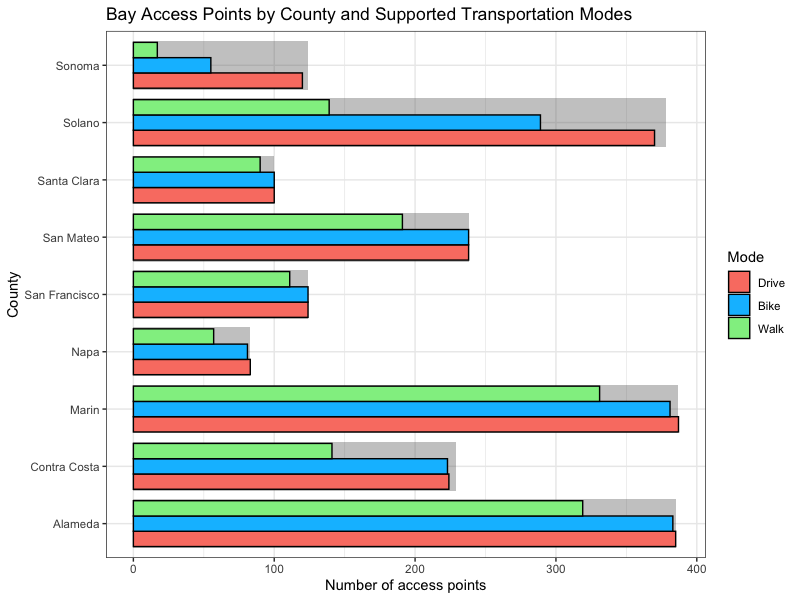

In [32]:
transport_modes_plot <- ggplot() +
  # Total access points by county (underlaid)
  geom_col(
    data = total_counts,
    aes(x = County_Name, y = n),
    alpha = 0.35, width = 0.85
  ) +
  # Access points by county + transport mode (overlaid)
  geom_col(
    data = mode_counts, 
    aes(x = County_Name, y = n, fill = Mode),
    color = "black", position = "dodge", width = 0.8
  ) +
  scale_fill_manual(
    values = c(
      Walk = "lightgreen",
      Bike = "deepskyblue",
      Drive = "salmon",
      Total = "grey"
    )
  ) +
  coord_flip() +
  labs(
    title = "Bay Access Points by County and Supported Transportation Modes",
    x = "County", 
    y = "Number of access points"
  ) +
  theme_bw()

transport_modes_plot

### **2. Public Transit to Access Points**

In [93]:
county_order <- transit %>%
    arrange(County_Name) %>%
    pull(County_Name) %>%
    unique()

# olu_order <- transit %>%
#   mutate(County_Name = factor(County_Name, levels = county_order)) %>%
#   distinct(County_Name, OLU_Name) %>%  
#   arrange(County_Name, OLU_Name) %>%
#   pull(OLU_Name)

county_order

[1] "Alameda"       "Contra Costa"  "Marin"         "Napa"          "San Francisco" "San Mateo"     "Santa Clara"   "Solano"       
[9] "Sonoma"       

In [100]:
transit_sub <- transit %>%
  mutate(
    County_Name = factor(County_Name, levels = county_order),
    # OLU_Name = factor(OLU_Name, levels = olu_order),
    County_OLU = paste(County_Name, "-", OLU_Name)
  ) %>%
  filter(County_Name != "San Francisco")
  # filter((OLU_Name != "Mission - Islais") & (OLU_Name != "Golden Gate"))

county_olu_order <- transit_sub %>%
  arrange(desc(County_OLU)) %>%
  pull(County_OLU) %>%
  unique()

transit_sub <- transit_sub %>%
  mutate(County_OLU = factor(County_OLU, levels = county_olu_order))

head(transit_sub, 10)

# A tibble: 10 × 20
   Access_Point_ID Access_Type County_Name Subembayment_Name OLU_Name Public_Transit_Stops sum_n_routes n_service_types Walk  Bike 
             <int> <chr>       <fct>       <chr>             <chr>                   <int>        <dbl>           <int> <lgl> <lgl>
 1               2 Shoreline … Contra Cos… San Pablo Bay     Pinole                      0            0               2 FALSE TRUE 
 2               3 Shoreline … Contra Cos… San Pablo Bay     Pinole                      2            4               3 TRUE  TRUE 
 3               6 Water Trail Sonoma      San Pablo Bay     Petaluma                    0            0               1 FALSE FALSE
 4               7 Marsh       San Mateo   South Bay         Belmont…                    0            0               3 TRUE  TRUE 
 5               9 Bay Trail   Alameda     Central Bay       San Lea…                    2            2               3 TRUE  TRUE 
 6              11 Shoreline … Alameda     Central Bay  

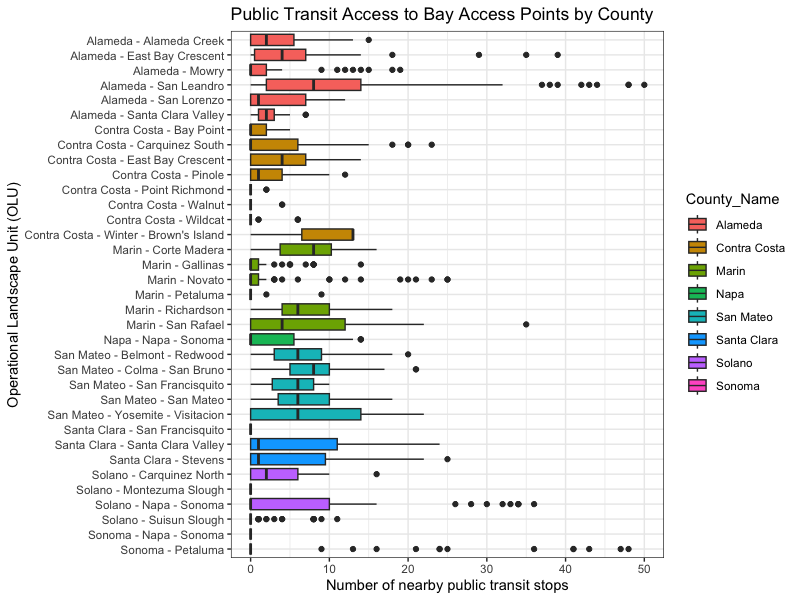

In [103]:
ggplot(transit_sub, aes(x = County_OLU, y = Public_Transit_Stops, fill = County_Name)) +
  geom_boxplot() +
  coord_flip() +
  labs(
    title = "Public Transit Access to Bay Access Points by County",
    x = "Operational Landscape Unit (OLU)",
    y = "Number of nearby public transit stops"
  ) +
  theme_bw()

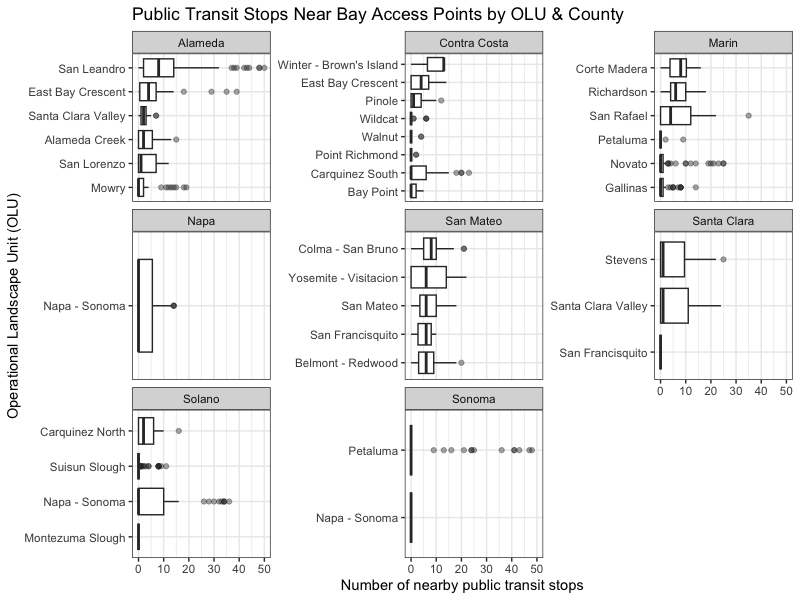

In [ ]:
transit_OLUs <- transit_sub %>%
  group_by(County_Name, OLU_Name) %>%
  mutate(olu_med = median(Public_Transit_Stops, na.rm = TRUE)) %>%
  ungroup() %>%
  mutate(OLU_in_county = reorder_within(OLU_Name, olu_med, County_Name))

ggplot(transit_OLUs, aes(x = OLU_in_county, y = Public_Transit_Stops)) +
  geom_boxplot(outlier.alpha = 0.4) +
  facet_wrap(~ County_Name, scales = "free_y") +
  coord_flip() +
  scale_x_reordered() +
  labs(
    title = "Public Transit Stops Near Bay Access Points by OLU & County",
    x = "Operational Landscape Unit (OLU)",
    y = "Number of nearby public transit stops"
  ) +
  theme_bw()

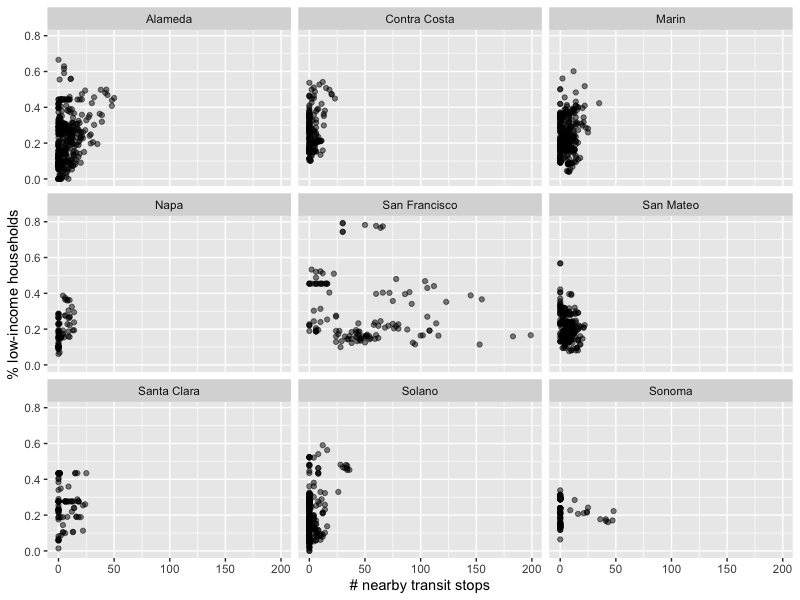

In [46]:
ggplot(transit, aes(x = Public_Transit_Stops, y = hh_pct_low_income)) +
  geom_point(alpha = 0.5) +
  facet_wrap(~ County_Name) +
  labs(x = "# nearby transit stops", y = "% low-income households")

### **3. County Demographic Information**

In [8]:
counties <- access_raw %>% 
  group_by(County_Name) %>%
  summarize(
    "num_pts" = length(unique(Access_Point_ID)),
    "num_households" = sum(SUM_Estimated_Total_Households),
    "est_poc_pct" = sum(SUM_Estimated_People_of_Color) / sum(SUM_Estimated_Total_Population)
  )

counties

# A tibble: 9 × 4
  County_Name   num_pts num_households est_poc_pct
  <chr>           <int>          <dbl>       <dbl>
1 Alameda           385      42908798.       0.713
2 Contra Costa      229       9698540.       0.758
3 Marin             387      10412270.       0.336
4 Napa               83       1966613.       0.560
5 San Francisco     124      33228941.       0.581
6 San Mateo         238      16323718.       0.615
7 Santa Clara       100       6956014.       0.692
8 Solano            378       6419128.       0.717
9 Sonoma            124        703918.       0.320

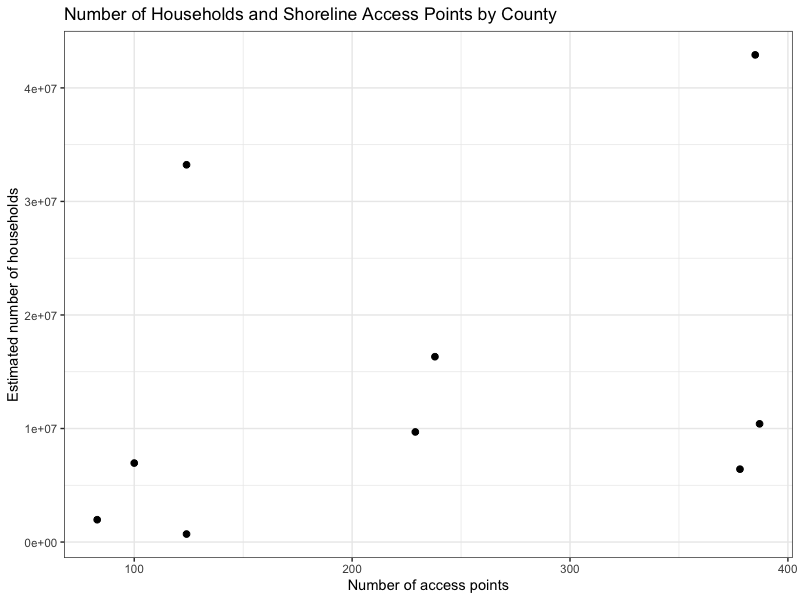

In [9]:
ggplot(counties, aes(x = num_pts, y = num_households)) +
  geom_point(size = 2) +
  labs(
    title = "Number of Households and Shoreline Access Points by County",
    x = "Number of access points",
    y = "Estimated number of households"
  ) +
  theme_bw()